In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from numpy.random import default_rng
import seaborn as sns
import pandas as pd

In [2]:
N = int(1e6)
N_sims = 1000
t_max = 700
I0 = 1

b    = 0.2
mu   = 0.1
r_b  = 0.05
b_f  = 0.7
mu_f = 0.015

frac = 0.001

init = {"S"   : N-I0,
        "S_f" : 0,
        "I"   : I0,
        "R"   : 0,
       }

rng = default_rng()

In [3]:
def simulate(init, t_max):

    compartments = {"S"  : init["S"],
                    "S_f": init["S_f"],
                    "I"  : init["I"],
                    "R"  : init["R"],
                   }
    
    time_series = {"S"  : [init["S"]],
                   "S_f": [init["S_f"]],
                   "I"  : [init["I"]],
                   "R"  : [init["R"]],
                   }

    for t in range(0, t_max):
        S, S_f, I, R = list(compartments.values())

        ##### TRANSMISSION PROCESSES #####
        # The convention is dABC for a process A + B -> C + B

        # Disease Transmission for S compartment #
        # S + I -(b)-> I + I
        dSII = rng.binomial(S, b*I/N)

        # Disease Transmission for S_f compartment #
        # S_f + I -(r_b*b)-> I + I
        dS_fII = rng.binomial(S_f, r_b*b*I/N)

        # Fear Transmission #
        # S + I -(b_f)-> S_f + I
        dSIS_f = rng.binomial(S, b_f*I/N)

        # Overcoming the fear after contact with R #
        # S_f + R -(mu_f)-> S + R
        dS_fRS = rng.binomial(S_f, mu_f*R/N)

        # Overcoming the fear after contact with S #
        # S_f + S -(mu_f)-> S + S
        dS_fSS = rng.binomial(S_f, mu_f*S/N)

        ##### TRANSITION PROCESSES #####

        # Healing #
        # I -(mu)-> R
        dIR = rng.binomial(I, mu)

        ##################################################################
        #                     # dSII# dS_fII# dSIS_f# dS_fRS# dS_fSS# dIR#
        #                     #     #       #       #       #       #    #
        ##################################################################    
        compartments["S"]   += -dSII         -dSIS_f +dS_fRS +dS_fSS     #
        #                     #     #       #       #       #       #    #
        #######################     #       #       #       #       #    #
        compartments["S_f"] +=       -dS_fII +dSIS_f -dS_fRS -dS_fSS     #
        #                     #     #       #       #       #       #    #
        #######################     #       #       #       #       #    #
        compartments["I"]   += +dSII +dS_fII                         -dIR#
        #                     #     #       #       #       #       #    #
        #######################     #       #       #       #       #    #
        compartments["R"]   +=                                       +dIR#
        #                     #     #       #       #       #       #    #
        ##################################################################

        for key in compartments:
            compartments[key] = np.clip(compartments[key], 0, N)
            time_series[key].append(compartments[key])

        tt = np.linspace(0, t_max, t_max+1)
        
    return tt, time_series

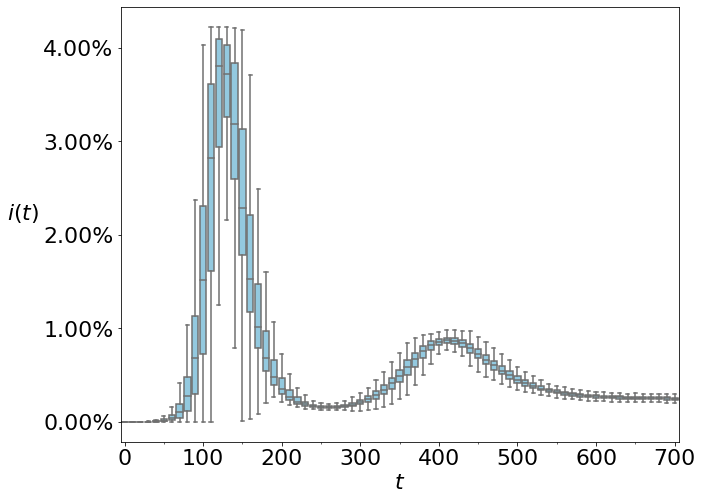

CPU times: user 1min 30s, sys: 463 ms, total: 1min 30s
Wall time: 1min 30s


In [4]:
%%time

# Let's create a matrix "sims_matrix" with N_sims rows and t_max columns,
# each row represents the time-series of a single simulation

step = 10

fontsize = 22

sims_matrix = np.zeros((N_sims, t_max+1))

fig, ax = plt.subplots(figsize=(10, 8))
#plt.suptitle("$N={}, i_0=1/N, \\beta={}, \mu={}, $".format(N, b, mu) + \
#             "$r_\\beta={}, \\beta_F={}, \mu_F={}$".format(r_b, b_f, mu_f), fontsize=18)
ax.set_xlabel('$time[days]$', fontsize = fontsize)
ax.set_ylabel('I(t)', fontsize = fontsize, labelpad = 20).set_rotation(0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter()) #display "%" sign on y axis


for i, row in enumerate(sims_matrix):
    print("{}/{}".format(i+1, len(sims_matrix)), end='\r')
    tt, result = simulate(init, t_max)
    
    if(result["R"][-1] >= frac * N): # Only keep runs where the desease reaches a significant fraction of the pupulation
        row[:] = [elem*100/N for elem in result["I"]]
        #plt.plot(tt, [ elem/N for elem in result["I"] ], color=(0.1, 0.1, 0.1, 0.2), linestyle='dotted')

sims_matrix = sims_matrix[~np.all(sims_matrix == 0, axis=1)]

tt = np.linspace(0, t_max, t_max+1)
tt_step = np.array([int(t) for t in tt[::step]])

df_dict = {'time':[],
           'i': []
          }

for t in tt_step:
    for row in sims_matrix:
        df_dict['time'].append(t)
        df_dict['i'].append(row[t])

df = pd.DataFrame(df_dict)

boxplot = sns.boxplot(x='time', y='i', data=df, color="skyblue", ax=ax, showfliers = False)

#ave = np.average(sims_matrix, axis=0)
#fake_tt = np.linspace(0, len(tt_step)-1, len(ave))
#ax.plot(fake_tt, ave, color="k", linestyle="solid", linewidth=3, label="Average")

#plt.xlim(0, t_max)
#ax.xaxis.set_major_locator(mtick.MultipleLocator(step))
#ax.xaxis.set_major_formatter(mtick.ScalarFormatter())

ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.xaxis.set_minor_locator(mtick.MultipleLocator(5))

#ax.xaxis.set_major_formatter(mtick.ScalarFormatter())

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('$i(t)$', fontsize=fontsize)
plt.xlabel('$t$', fontsize=fontsize)

#fig.tight_layout()
plt.show()
#plt.legend()